In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
import DarkVerse as dv


In [3]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'
}


#subset = (t['z'] > 0.6) & (t['z'] < 0.7) & (t['SM']>10.5)& (t['SM']<11) #solar masses


z_min=0.6
z_max=0.7
SM_min=10.5
SM_max=11

# Select Subsample
subsample = dv.Subsample(catalog=t, randoms=randoms, z_min=z_min, z_max=z_max, SM_min=SM_min, SM_max=SM_max, config=config)

# Get Results
results = subsample.get_results()

print(f"Power Law Parameters (A, gamma): {results['power_law_params']}")
print()
#print(f"w_theta: {results['w_theta']}")
#print(f"DD counts: {results['dd_counts']}")
#print(f"DR counts: {results['dr_counts']}")
#print(f"RR counts: {results['rr_counts']}")


The following patch numbers have no objects: {194, 258, 357, 10, 138, 298, 364, 396, 399, 145, 178, 276, 374, 376, 413}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


Power Law Parameters (A, gamma): [7.78533325e-04 1.39070574e+00]



Errors on w_theta: [1.31308807 1.58008156 0.71281396 1.18954496 0.63915194 0.64524289
 0.55806635 0.56283634 0.58388936 0.50191527 0.29975573 0.47181599
 0.41959513 0.29419163 0.4275647  0.44587287 0.39986117 0.34888032
 0.31915879 0.36337404 0.30436222 0.2850452  0.25773326 0.22546779
 0.19769165 0.1802622  0.16170366 0.15481102 0.14753034 0.14096205
 0.13357817 0.12852776 0.11713785 0.10352714 0.10539434 0.0979942
 0.09544172 0.07494562 0.07635914 0.06911266 0.06775186 0.06105902
 0.05833887 0.05202759 0.04889153 0.04875127 0.04753017 0.04915516
 0.04301595 0.03962582 0.03376599 0.03429875 0.03370528 0.03283788
 0.03182384 0.02925057 0.02845802 0.02688624 0.02645281 0.0252619
 0.02297408 0.02780076 0.0293599  0.04125562]


/tmp/ipykernel_71959/2901281716.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


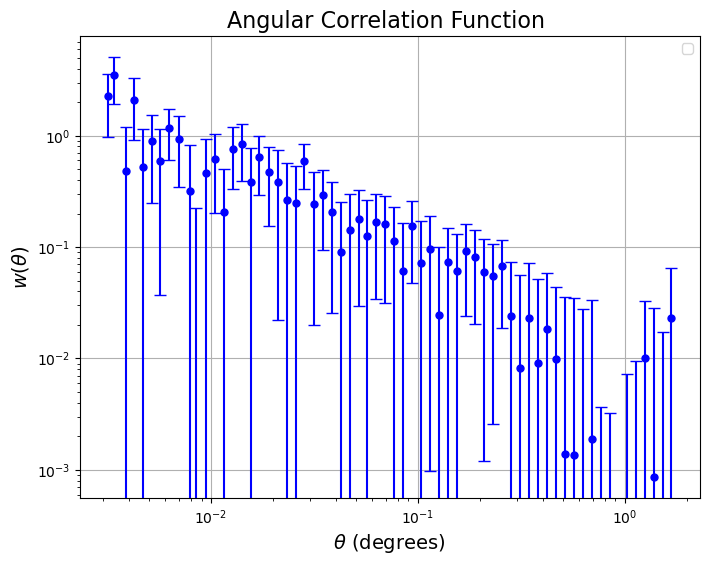

In [4]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)


plt.figure(figsize=(8, 6))
plt.errorbar(theta_values, w_theta_values, yerr= w_theta_errors, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()


### ^these errors are way too big wtf is going on??

In [5]:
gg = subsample.compute_gg()  



In [6]:
print(f"xi g: {results['xi_g']}")


xi g: [6.66679932e+00 6.05230548e+00 5.47516464e+00 4.93557947e+00
 4.43344531e+00 3.96837730e+00 3.53966878e+00 3.14635172e+00
 2.78718754e+00 2.46075753e+00 2.16559355e+00 1.89961711e+00
 1.65974464e+00 1.44437896e+00 1.25274720e+00 1.08287938e+00
 9.32052703e-01 7.97691477e-01 6.77192249e-01 5.67040902e-01
 4.60633908e-01 3.72888314e-01 3.09097687e-01 2.63261868e-01
 2.30538647e-01 2.07169755e-01 1.90288229e-01 1.77754441e-01
 1.68015091e-01 1.59982051e-01 1.52926523e-01 1.46385973e-01
 1.40086168e-01 1.33877345e-01 1.27686223e-01 1.21483690e-01
 1.15264669e-01 1.09037134e-01 1.02815842e-01 9.66192995e-02
 9.04686047e-02 8.43871931e-02 7.83994317e-02 7.25286179e-02
 6.67971463e-02 6.12276951e-02 5.58416471e-02 5.06587709e-02
 4.56982324e-02 4.09771450e-02 3.65112507e-02 3.23132164e-02
 2.83926927e-02 2.47559377e-02 2.14065439e-02 1.83459588e-02
 1.55726910e-02 1.30813951e-02 1.08641148e-02 8.91167010e-03
 7.21228309e-03 5.75192124e-03 4.51550383e-03 3.48349254e-03]


In [7]:


# Compute correlation functions
theta, xi_g, xi_m = subsample.compute_gg()

# Retrieve all results
results = subsample.get_results()

# Print key outputs
print("Galaxy-Galaxy Angular Correlation:", results['xi_g'])
print("Matter-Matter Angular Correlation:", results['xi_m'])


Galaxy-Galaxy Angular Correlation: [6.66679932e+00 6.05230548e+00 5.47516464e+00 4.93557947e+00
 4.43344531e+00 3.96837730e+00 3.53966878e+00 3.14635172e+00
 2.78718754e+00 2.46075753e+00 2.16559355e+00 1.89961711e+00
 1.65974464e+00 1.44437896e+00 1.25274720e+00 1.08287938e+00
 9.32052703e-01 7.97691477e-01 6.77192249e-01 5.67040902e-01
 4.60633908e-01 3.72888314e-01 3.09097687e-01 2.63261868e-01
 2.30538647e-01 2.07169755e-01 1.90288229e-01 1.77754441e-01
 1.68015091e-01 1.59982051e-01 1.52926523e-01 1.46385973e-01
 1.40086168e-01 1.33877345e-01 1.27686223e-01 1.21483690e-01
 1.15264669e-01 1.09037134e-01 1.02815842e-01 9.66192995e-02
 9.04686047e-02 8.43871931e-02 7.83994317e-02 7.25286179e-02
 6.67971463e-02 6.12276951e-02 5.58416471e-02 5.06587709e-02
 4.56982324e-02 4.09771450e-02 3.65112507e-02 3.23132164e-02
 2.83926927e-02 2.47559377e-02 2.14065439e-02 1.83459588e-02
 1.55726910e-02 1.30813951e-02 1.08641148e-02 8.91167010e-03
 7.21228309e-03 5.75192124e-03 4.51550383e-03 3.48

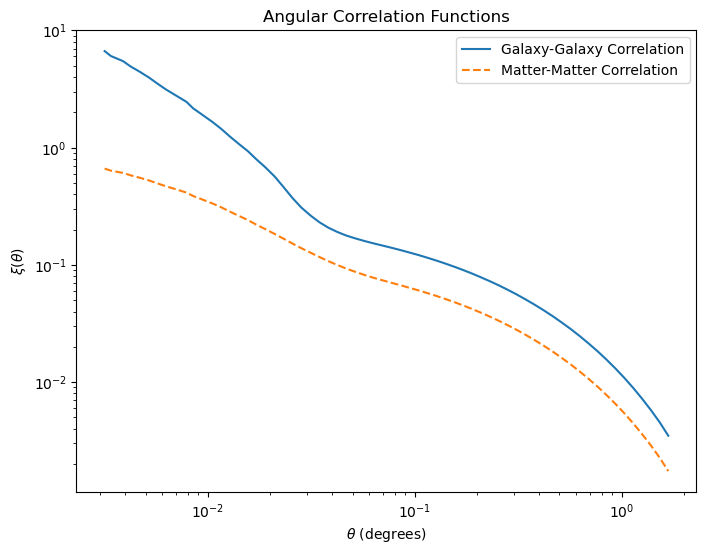

In [8]:
plt.figure(figsize=(8,6))
plt.loglog(results['theta'], results['xi_g'], label='Galaxy-Galaxy Correlation')
plt.loglog(results['theta'], results['xi_m'], label='Matter-Matter Correlation', linestyle='dashed')

plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi(\theta)$')
plt.legend()
plt.title('Angular Correlation Functions')
plt.show()


Errors on w_theta: [1.31308807 1.58008156 0.71281396 1.18954496 0.63915194 0.64524289
 0.55806635 0.56283634 0.58388936 0.50191527 0.29975573 0.47181599
 0.41959513 0.29419163 0.4275647  0.44587287 0.39986117 0.34888032
 0.31915879 0.36337404 0.30436222 0.2850452  0.25773326 0.22546779
 0.19769165 0.1802622  0.16170366 0.15481102 0.14753034 0.14096205
 0.13357817 0.12852776 0.11713785 0.10352714 0.10539434 0.0979942
 0.09544172 0.07494562 0.07635914 0.06911266 0.06775186 0.06105902
 0.05833887 0.05202759 0.04889153 0.04875127 0.04753017 0.04915516
 0.04301595 0.03962582 0.03376599 0.03429875 0.03370528 0.03283788
 0.03182384 0.02925057 0.02845802 0.02688624 0.02645281 0.0252619
 0.02297408 0.02780076 0.0293599  0.04125562]


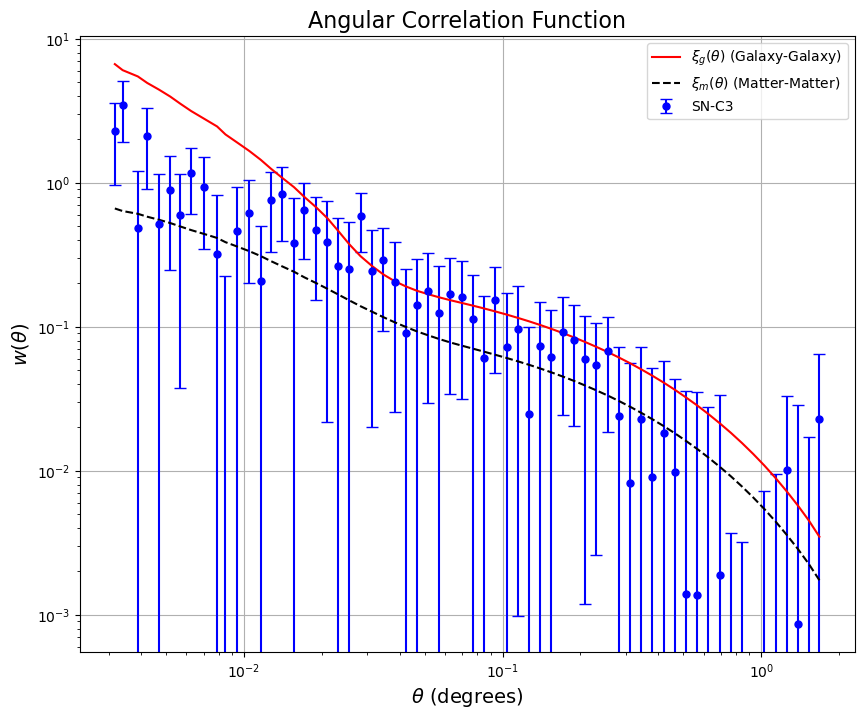

In [9]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']
xi_g_values = results['xi_g']
xi_m_values = results['xi_m']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)

plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


In [10]:


bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list=[results['w_theta']], 
    w_theta_error_list=[results['var_w_theta']], 
    sum_rr_list=[results['rr_counts']], 
    mask = (theta_values >= 0.1) & (theta_values <= 0.4)
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [1.4139232449816659]
Bias errors: [0.008678624344922153]


In [11]:
xi_m_values = np.array(results['xi_m'])  # Matter-matter correlation function
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction

# Compute the model: xi_m * b^2 - IC
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

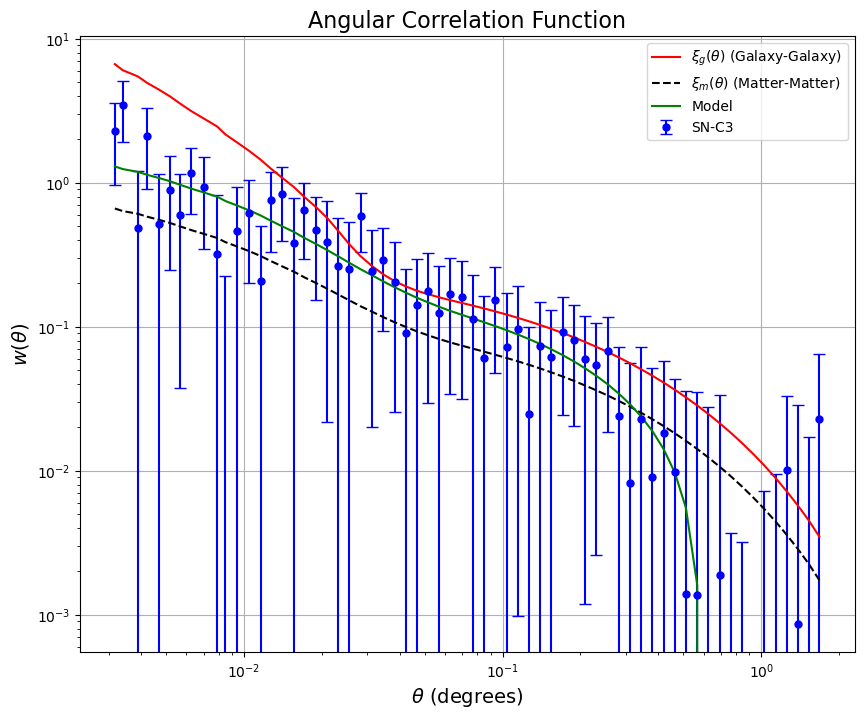

In [12]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

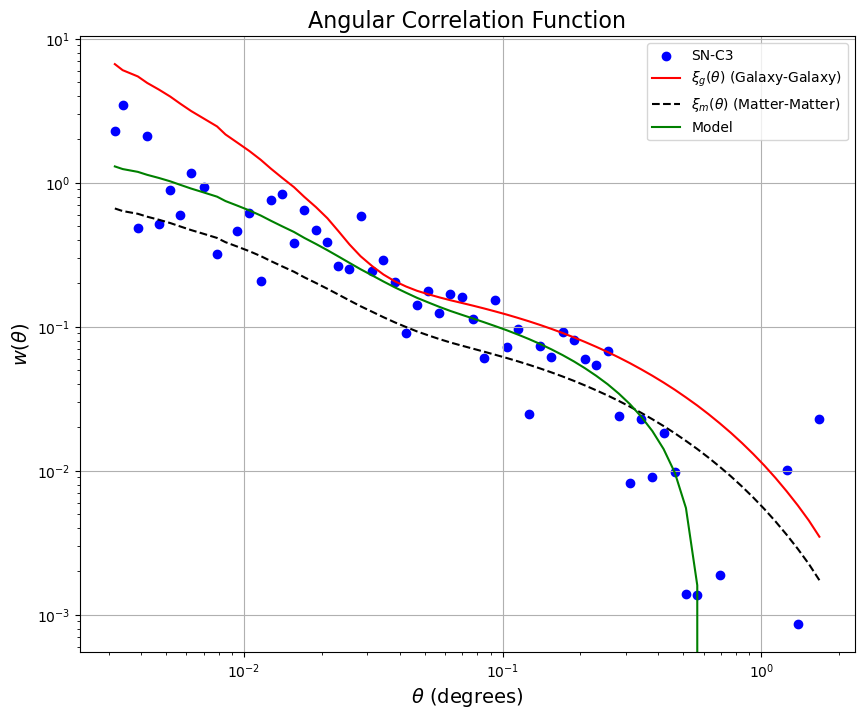

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(theta_values, w_theta_values,  
             color='blue',  label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

plt.legend()
plt.grid(True)

plt.show()

In [14]:

print("\n--- Subsample Information ---")
print(f"Redshift range: {subsample.z_min} ≤ z ≤ {subsample.z_max}")
print(f"Stellar Mass range: {subsample.SM_min} ≤ SM ≤ {subsample.SM_max}")
print(f"Number of galaxies in subsample: {len(subsample.filtered_catalog)}")



--- Subsample Information ---
Redshift range: 0.6 ≤ z ≤ 0.7
Stellar Mass range: 10.5 ≤ SM ≤ 11
Number of galaxies in subsample: 927


In [ ]:
bootstrap_w_theta = []

for i in range(100):  
    sample_indices = np.random.choice(len(subsample.filtered_catalog), size=len(subsample.filtered_catalog), replace=True)
    bs_galaxies = subsample.filtered_catalog[sample_indices]
    
    bs_corr = dv.CorrelationFunction(bs_galaxies, randoms, config)
    bs_corr.process()
    w_theta_bs, _, _ ,_, _, _ = bs_corr.calculate_w_theta()
    
    bootstrap_w_theta.append(w_theta_bs)

variance_bootstrap = np.var(bootstrap_w_theta, axis=0)
covariance = np.cov(bootstrap_w_theta)


The following patch numbers have no objects: {386, 3, 261, 389, 395, 268, 269, 142, 15, 398, 145, 273, 147, 274, 21, 150, 279, 401, 153, 282, 404, 156, 29, 158, 407, 408, 168, 44, 175, 304, 433, 306, 310, 438, 440, 185, 441, 443, 444, 319, 321, 195, 324, 329, 458, 205, 335, 338, 90, 352, 353, 100, 233, 363, 236, 367, 114, 370, 372, 374, 119, 248, 251, 124, 253}
This may be a problem depending on your use case.
The following patch numbers have no objects: {387, 391, 393, 394, 139, 268, 397, 16, 401, 402, 19, 277, 153, 156, 28, 412, 289, 163, 422, 168, 296, 170, 424, 425, 427, 46, 302, 429, 305, 50, 51, 430, 431, 433, 312, 187, 189, 318, 192, 65, 453, 326, 457, 331, 338, 86, 214, 218, 346, 349, 101, 368, 241, 242, 244, 119, 124}
This may be a problem depending on your use case.
The following patch numbers have no objects: {256, 129, 385, 386, 387, 383, 397, 15, 16, 144, 273, 399, 400, 403, 150, 26, 288, 419, 44, 173, 178, 184, 440, 187, 189, 448, 194, 322, 325, 198, 453, 328, 202, 203, 7

In [ ]:


def count_pairs_in_theta_bin(cat, theta_edges):
    """Counts the number of galaxy pairs within specific theta bins."""
    
    # Convert catalog RA, Dec to SkyCoord object
    coords = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
    
    # Compute angular separations between all pairs
    separation = coords[:, np.newaxis].separation(coords)
    
    # Convert separation to log10 and bin
    theta_hist, _ = np.histogram(np.log10(separation.arcmin), bins=theta_edges)

    return theta_hist


In [ ]:
def count_pairs(catalog, random_catalog, theta_edges):
    
    separation = catalog.separation(random_catalog[:, np.newaxis]) #Calculates the angular separation between all pairs of objects in a catalog.
    pair_counts,_= np.histogram(np.log10(separation.value),bins=theta_edges)


    return pair_counts


In [ ]:


# Parameters for bootstrap
num_bootstrap_samples = 100  
theta_edges = np.linspace(-2.5, 0.25, 50)  # Log of min and max separation in degrees

results = subsample.get_results()

theta_values = results['theta']
w_theta_values = results['w_theta']
xi_m_values = results['xi_m']
rr_counts = results['rr_counts']

N = len(subsample.filtered_catalog)  # Number of galaxies in the subsample
w_theta_bootstrap = []  # Store w_theta for each bootstrap sample

for j in range(num_bootstrap_samples):
    # Generate bootstrap sample indices
    sample_indices = np.random.choice(np.arange(N), size=N, replace=True)
    bs_galaxies = subsample.filtered_catalog[sample_indices]

    # Compute DD and DR using the bootstrap sample
    dd_counts = count_pairs_in_theta_bin(bs_galaxies, theta_edges)
    dr_counts = count_pairs(bs_galaxies, subsample.randoms, theta_edges)

    # Normalize the counts
    dd = dd_counts / np.sum(dd_counts)
    rr = rr_counts / np.sum(rr_counts)
    dr = dr_counts / np.sum(dr_counts)

    # Compute bootstrap w(θ) using the Landy & Szalay (1993) estimator
    w_theta = (dd - 2 * dr + rr) / rr
    w_theta_bootstrap.append(w_theta)

# Compute variance and covariance matrix from bootstrap samples
variance = np.var(w_theta_bootstrap, axis=0)
covariance = np.cov(w_theta_bootstrap)

# Bias estimation
bias_estimator = BiasEstimator(
    subsample.xi_g,
    [w_theta_values],
    [np.sqrt(variance)],  # Bootstrap errors
    [rr_counts],
    mask=np.ones_like(theta_values, dtype=bool)
)
bias_values, bias_errors = bias_estimator.estimate_bias()
IC = bias_estimator.integral_constraint(xi_m_values, rr_counts)

# Plot the bootstrap result
plt.figure(figsize=(8, 6))
plt.errorbar(theta_values, w_theta_values, yerr=np.sqrt(variance), fmt='o', color='blue', capsize=4, markersize=5, label='Data')
plt.plot(theta_values, xi_m_values * bias_values[0]**2 - IC, label='Model', color='g')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'Angular Correlation Function (Single Subsample)', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Print subsample info
print("\nSubsample Information:")
print(f"  - Redshift range: {subsample.z_min} ≤ z < {subsample.z_max}")
print(f"  - Stellar mass range: {subsample.SM_min:.1e} ≤ SM < {subsample.SM_max:.1e}")
print(f"  - Number of galaxies: {N}")
print(f"  - Bias: {bias_values[0]:.3f} ± {bias_errors[0]:.3f}")
